In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 基本配置参数

In [3]:
uldlcfgidx = 1

# Log路径设置

In [4]:
root_path = r'E:\故障分析\MU_20170110_guole\远点'
path_3162_mu = root_path + r'\3.1.6.2\mu'
path_3162_normal = root_path + r'\3.1.6.2\normal'
path_3162new_mu = root_path + r'\3.1.6.2new\mu'
path_3162new_normal = root_path + r'\3.1.6.2new\normal'
path_3181_mu = root_path + r'\3.1.8.3P01\mu'
path_3181_normal = root_path + r'\3.1.8.3P01\normal'

# 流量分析

In [5]:
def calc_throuput(data_dir, col_label, airtime_bin=1000):
    cols = ['AirTime', 'TB.u16TbSize', 'TB.u8TxCnt']
    rlt = pd.DataFrame()
    for file in os.listdir(data_dir):
        name = os.path.join(data_dir, file)
        schddata = pd.read_csv(name, na_values='-', usecols=cols)
        schddata = schddata[schddata[cols[2]]==1].astype(np.uint32)
        schddata[cols[0]] = schddata[cols[0]].map(lambda x: x//16*10+x%16)
        grouped = schddata[cols[1]].groupby(schddata[cols[0]]//airtime_bin).sum()
        rlt = pd.concat([rlt,grouped.iloc[1:-1]], ignore_index=True)
    rlt.index.name = 'AirTime(s)'
    rlt.columns = [col_label]
    return rlt[col_label].astype(np.uint32)

In [6]:
thruput_3162_normal = calc_throuput(path_3162_normal, col_label='3162_normal')
thruput_3162new_normal = calc_throuput(path_3162new_normal, col_label='3162new_normal')
thruput_3181_normal = calc_throuput(path_3181_normal, col_label='3181_normal')
thruput_3162_mu = calc_throuput(path_3162_mu, col_label='3162_mu')
thruput_3162new_mu = calc_throuput(path_3162new_mu, col_label='3162new_mu')
thruput_3181_mu = calc_throuput(path_3181_mu, col_label='3181_mu')
thruput = pd.concat([thruput_3162_normal, thruput_3162new_normal, thruput_3181_normal, thruput_3162_mu, thruput_3162new_mu, thruput_3181_mu], axis=1)

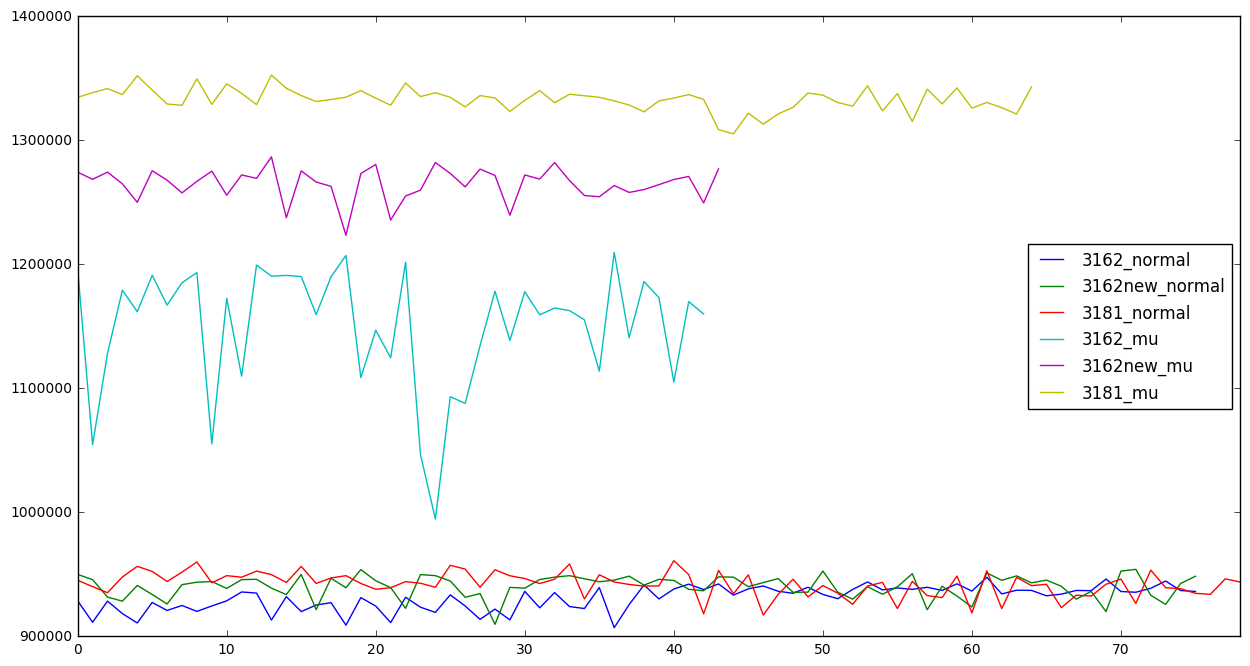

In [7]:
thruput.plot(kind='line', figsize=(15,8))

## MU增益

In [8]:
thruput.mean()

3162_normal       9.309178e+05
3162new_normal    9.402496e+05
3181_normal       9.422613e+05
3162_mu           1.150242e+06
3162new_mu        1.264808e+06
3181_mu           1.333008e+06
dtype: float64

## MU比例

In [9]:
def calc_muratio(data_dir, col_label, is3181patch=False, airtime_bin=1000):
    if is3181patch:
        cols = ['AirTime', 'GRANT.u8MatchType', 'TB.u8TxCnt']
    else:
        cols = ['AirTime', 'GRANT.u8IsMuMimoUe', 'TB.u8TxCnt']
    rlt = pd.DataFrame()
    for file in os.listdir(data_dir):
        name = os.path.join(data_dir, file)
        schddata = pd.read_csv(name, na_values='-', usecols=cols)
        schddata = schddata[schddata[cols[2]]==1].dropna(how='any').astype(np.uint32)
        schddata[cols[0]] = schddata[cols[0]].map(lambda x: x//16*10+x%16)
        grouped = schddata[cols[1]].groupby(schddata[cols[0]]//airtime_bin).apply(lambda x: 1- (x==0).astype(int).sum()/x.count())
        rlt = pd.concat([rlt,grouped.iloc[1:-1]], ignore_index=True)
    rlt.index.name = 'AirTime(s)'
    rlt.columns = [col_label]
    return rlt[col_label]

In [10]:
muratio_3162_mu = calc_muratio(path_3162_mu, col_label='muratio_3162_mu')
muratio_3162new_mu = calc_muratio(path_3162new_mu, col_label='muratio_3162new_mu')
muratio_3181_mu = calc_muratio(path_3181_mu, col_label='muratio_3181_mu', is3181patch=True)
muratio = pd.concat([muratio_3162_mu, muratio_3162new_mu, muratio_3181_mu], axis=1)

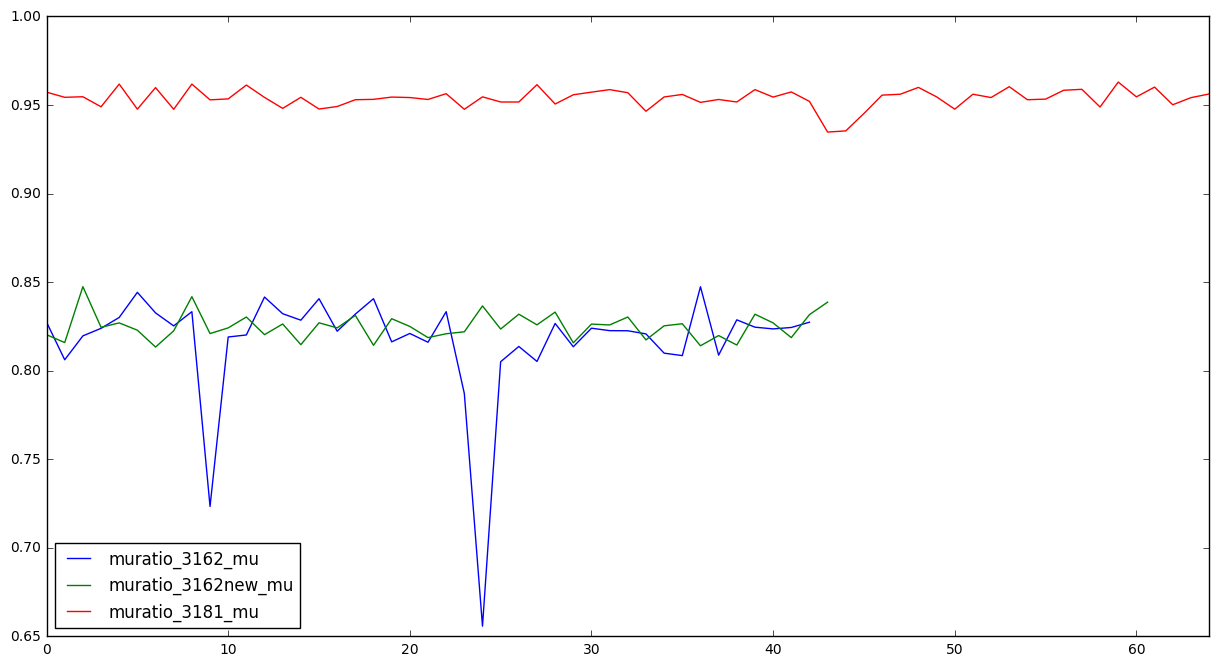

In [11]:
muratio.plot(kind='line', figsize=(15,8))

## D因子

In [12]:
def get_d_data(data_dir, col_label, is3181patch=False):
    if is3181patch:
        cols = ['MUMIMO.u32AverageD']
    else:
        cols = ['MUMIMO.u32AvgD']
    rlt = pd.DataFrame()
    for file in os.listdir(data_dir):
        name = os.path.join(data_dir, file)
        schddata = pd.read_csv(name, na_values='-', usecols=cols)
        schddata = schddata[schddata[cols[0]]>0].dropna(how='any').astype(np.uint32)
        schddata = schddata[cols[0]]/32767
        rlt = pd.concat([rlt,schddata], ignore_index=True)
    rlt.columns = [col_label]
    return rlt[col_label]

In [13]:
#d_3162_mu = get_d_data(path_3162_mu, col_label='3162_mu')
#d_3162new_mu = get_d_data(path_3162new_mu, col_label='3162new_mu')
#d_3181_mu = get_d_data(path_3181_mu, col_label='3181_mu', is3181patch=True)
#d = pd.concat([d_3162_mu, d_3162new_mu, d_3181_mu], axis=1)

In [14]:
#d.hist(sharex=True, sharey=True, normed=True, figsize=(15,5))
#d.plot(kind='kde')
#d.mean()

## BLER

In [15]:
LTE_SCHD_DLSUBFRM_OFFSET = ((0, 0, 7, 7, 5, 0, 0, 7, 7, 5),
                            (0, 0, 6, 4, 0, 0, 0, 6, 4, 0),
                            (0, 0, 4, 0, 0, 0, 0, 4, 0, 0),
                            (0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
                            (0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
                            (0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
                            (0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
                            (0, 0, 11, 12, 4, 5, 6, 7, 7, 8))
def schdtime(demtime):
    offset = LTE_SCHD_DLSUBFRM_OFFSET[uldlcfgidx]
    time = demtime//16*10+demtime%16 - offset[demtime%16]
    return time//10*16 + time%10
    
def match_schd_and_ack(file, cols, col_pre):
    demcols = ['FN', 'UEGID', 'CRCI.u8CrcHarqId']
    schdcols = ['AirTime', 'UEGID', 'GRANT.u8HarqId']
    if -1 == col_pre.find('_3181'):
        demcols[2] = 'CRCI.u32CrcHarqId'
        
    totcols = list(set(['CRCI.u32DemTime']+demcols+schdcols+cols))
    data = pd.read_csv(file, na_values='-', usecols=totcols)
    data['FN'] = data['CRCI.u32DemTime'].dropna().astype(np.uint32).map(schdtime)
    addcols = [col for col in cols if col.startswith('CRCI') or col.startswith('PUSCH_SINR')]
    matchcols = np.union1d(addcols, demcols)
    ackdata = data[matchcols]
    data = data.drop(np.setdiff1d(matchcols, ['UEGID']), axis=1)
    merged = pd.merge(data, ackdata, how='left', left_on=schdcols, right_on=demcols)
    return merged[cols]

In [16]:
def calc_bler(crc_data):
    acknum = (crc_data==1).astype(np.uint32).sum()
    totnum = crc_data.dropna().count()
    return 1- acknum /(totnum + 1)

def mu_bler_stat(data_dir, col_pre, by, airtime_bin=1000):
    cols = ['AirTime', 'GRANT.u8IsMuMimoUe', 'TB.u8TxCnt', 'CRCI.u32AckInfo']
    if -1 != col_pre.find('_3181'):
        cols[3] = 'CRCI.u8AckInfo'
        cols[1] = 'GRANT.u8MatchType'
 
    rlt = pd.DataFrame()
    for file in os.listdir(data_dir):
        name = os.path.join(data_dir, file)
        schddata = match_schd_and_ack(name, cols, col_pre)
        if by == 'mu':
            mask = (schddata[cols[2]]==1) & (schddata[cols[1]]!=0)
        elif by == 'normal':
            mask = (schddata[cols[2]]==1) & (schddata[cols[1]]==0)
        else:
            mask = schddata[cols[2]]==1
        schddata = schddata[mask]
        schddata[cols[0]] = schddata[cols[0]].astype(np.uint32).map(lambda x: x//16*10+x%16)
        grouped = schddata[cols[3]].groupby(schddata[cols[0]]//airtime_bin).apply(calc_bler)
        rlt = pd.concat([rlt,grouped.iloc[1:-1]], ignore_index=True)
    rlt.index.name = 'AirTime(s)'
    rlt.columns = ['bler']
    rlt.columns = [col_pre+name for name in rlt.columns]
    return rlt

In [17]:
mu_3162_bler = mu_bler_stat(path_3162_mu, col_pre='mu_3162_', by='mu') 
normal_3162_bler = mu_bler_stat(path_3162_normal, col_pre='normal_3162_', by='normal') 
mu_3162new_bler = mu_bler_stat(path_3162new_mu, col_pre='mu_3162new_', by='mu') 
normal_3162new_bler = mu_bler_stat(path_3162new_normal, col_pre='normal_3162new_', by='normal') 
mu_3181_bler = mu_bler_stat(path_3181_mu, col_pre='mu_3181_', by='mu') 
normal_3181_bler = mu_bler_stat(path_3181_normal, col_pre='normal_3181_', by='normal') 
bler = pd.concat([mu_3162_bler, mu_3162new_bler, mu_3181_bler, normal_3162_bler, normal_3162new_bler, normal_3181_bler], axis=1)

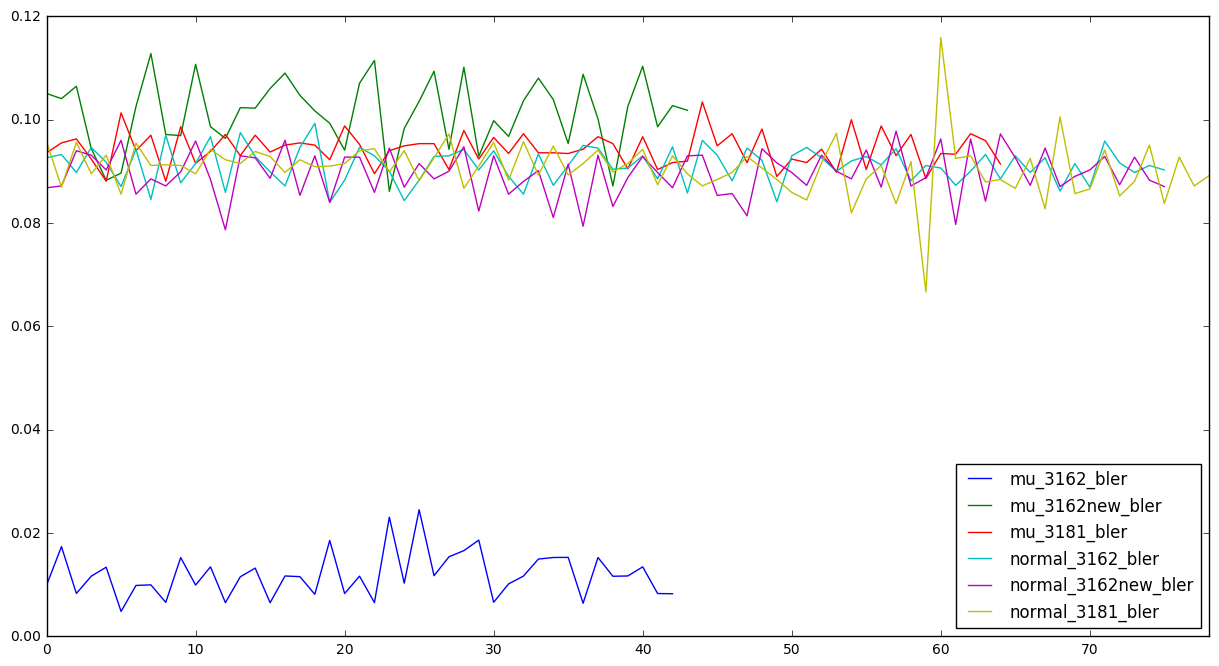

In [18]:
bler.plot(figsize=(15,8), kind='line')

## Mcs, rb, 1rbSinr

In [19]:
def muschd_stat(data_dir, col_pre, by, col):
    cols = ['GRANT.u8IsMuMimoUe', 'TB.u8TxCnt', col]
    if -1 != col_pre.find('_3181'):
        cols[0] = 'GRANT.u8MatchType'
 
    rlt = pd.Series()
    for file in os.listdir(data_dir):
        name = os.path.join(data_dir, file)
        schddata = pd.read_csv(name, na_values='-', usecols=cols)
        if by == 'mu':
            mask = (schddata[cols[1]]==1) & (schddata[cols[0]]!=0)
        elif by == 'normal':
            mask = (schddata[cols[1]]==1) & (schddata[cols[0]]==0)
        else:
            mask = schddata[cols[1]]==1
        schddata = schddata[mask].dropna().astype(np.uint32)
        rlt = pd.concat([rlt,schddata[col]],axis=0)
    rlt.name = col_pre
    return rlt.value_counts()/rlt.count()

In [20]:
def mu_data(by, col):
    mu_3162 = muschd_stat(path_3162_mu, col_pre='mu_3162', by=by, col=col) 
    normal_3162 = muschd_stat(path_3162_normal, col_pre='normal_3162', by='normal', col=col) 
    mu_3162new = muschd_stat(path_3162new_mu, col_pre='mu_3162new', by=by, col=col) 
    normal_3162new = muschd_stat(path_3162new_normal, col_pre='normal_3162new', by='normal', col=col) 
    mu_3181 = muschd_stat(path_3181_mu, col_pre='mu_3181', by=by, col=col) 
    normal_3181 = muschd_stat(path_3181_normal, col_pre='normal_3181', by='normal', col=col) 
    data = pd.concat([normal_3162, normal_3162new, normal_3181, mu_3162, mu_3162new, mu_3181], axis=1)
    return data

## 1RB_SINR

array([<matplotlib.axes._subplots.AxesSubplot object at 0x07ECBEB0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x080699F0>], dtype=object)

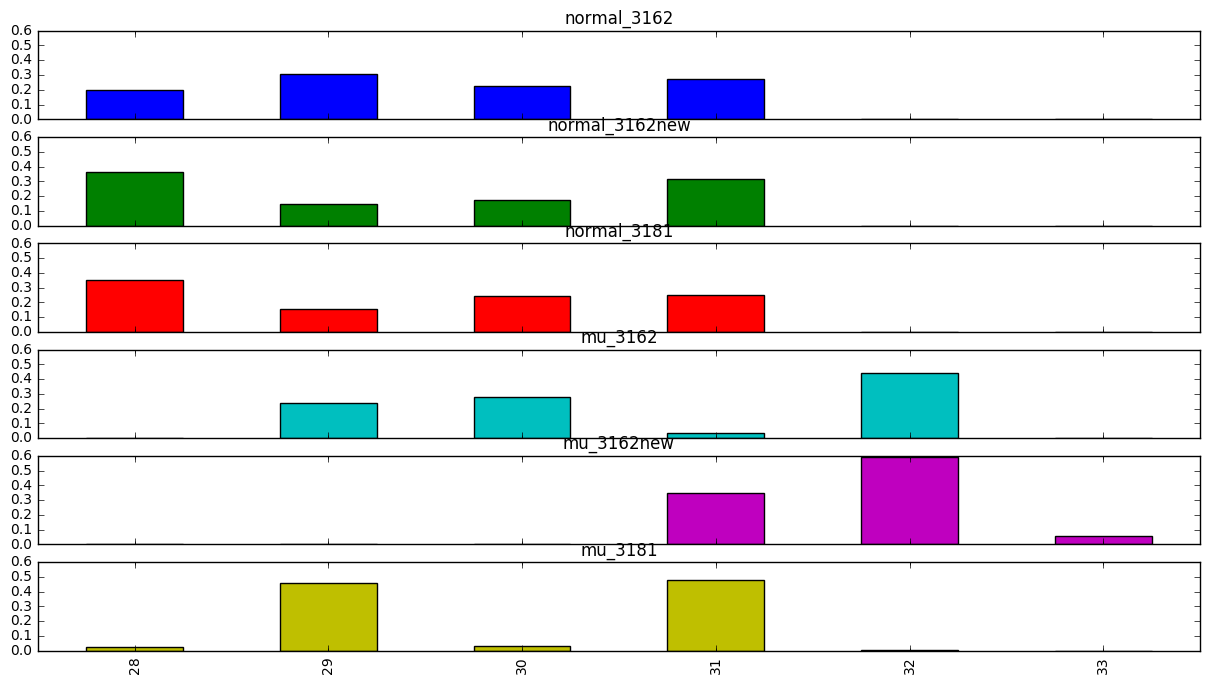

In [21]:
col = 'PUSCH_SINR.s16SingleRbSINR'
by = 'all'
sinr = mu_data(by, col)
sinr.plot(kind='bar', figsize=(15,8), subplots=True, legend=False, sharex=True, sharey=True)

## MCS

array([<matplotlib.axes._subplots.AxesSubplot object at 0x08125030>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x08753290>], dtype=object)

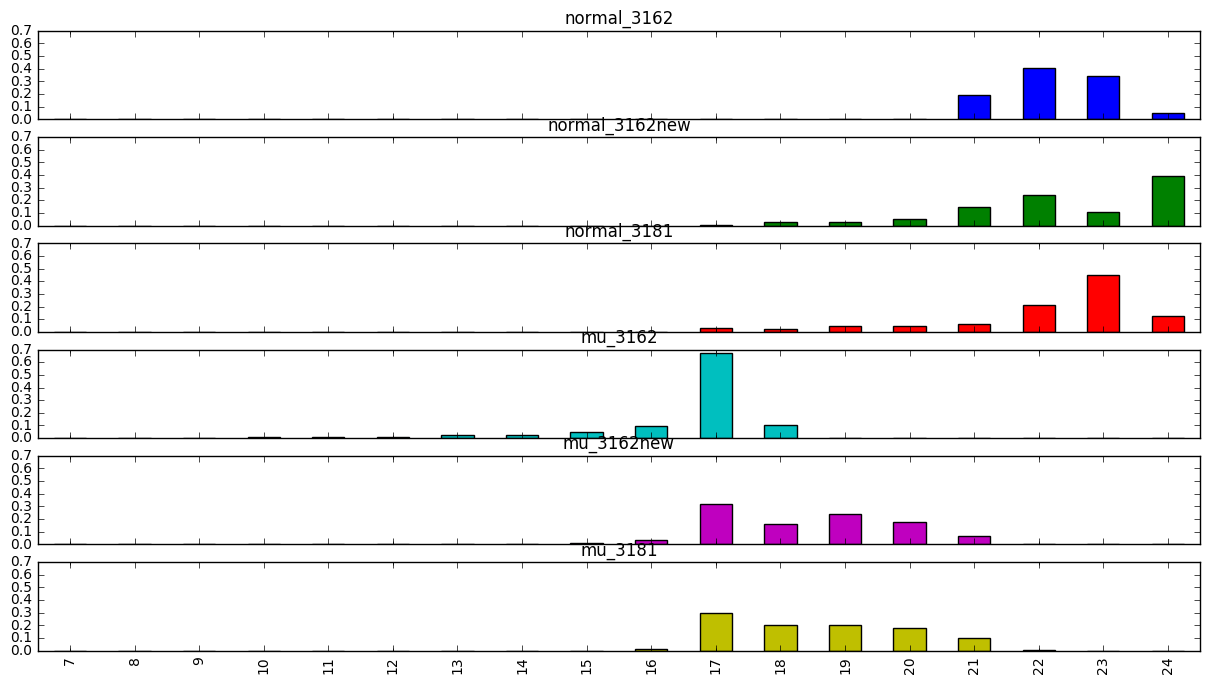

In [22]:
by = 'mu'
col = 'TB.u8Mcs'
mcs = mu_data(by, col)
mcs.plot(kind='bar', figsize=(15,8), subplots=True, legend=False, sharex=True, sharey=True)

## RB_Num

array([<matplotlib.axes._subplots.AxesSubplot object at 0x07F8AFB0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x09059030>], dtype=object)

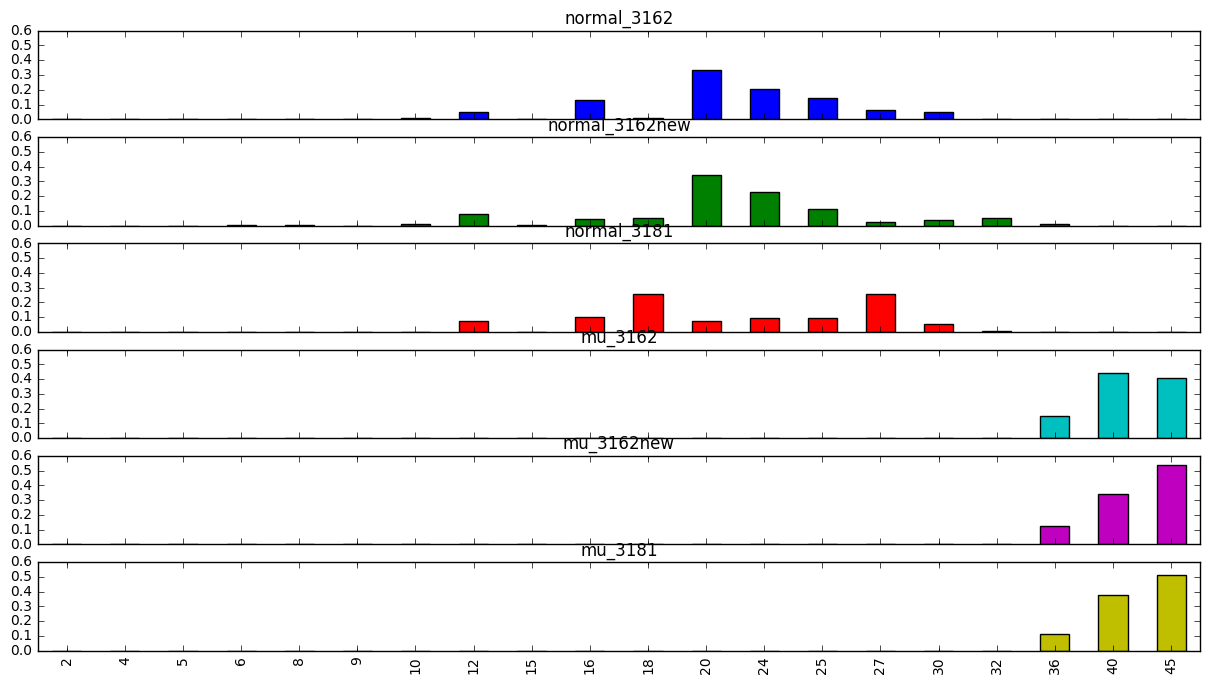

In [23]:
by = 'mu'
col = 'GRANT.u8RbNum'
rb = mu_data(by, col)
rb.plot(kind='bar', figsize=(15,8), subplots=True, legend=False, sharex=True, sharey=True)